<a href="https://colab.research.google.com/github/SkyHonor/Research-on-Deep-Learning-Algorithms/blob/main/one-shot-learning/sphere-net/ArcFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import torch
from PIL import Image, ImageFile

!wget http://usrbb.ru/botainika/Pepper.zip
!unzip Pepper.zip


transformation = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor()
                                    ])

data_path = datasets.ImageFolder(root="Pepper", transform = transformation)

train_dataloader = DataLoader(data_path,
                        shuffle=True,
                        num_workers=1,
                        batch_size=16)

KeyboardInterrupt: 

In [ ]:
from torchvision import models
import torch.nn as nn

class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = models.resnet50(pretrained=True)

        self.cnn1.fc = nn.Sequential(
            nn.Linear(self.cnn1.fc.in_features, 1280),
        )

    def forward(self, x):
        output = self.cnn1.conv1(x)
        output = self.cnn1.bn1(output)
        output = self.cnn1.relu(output)
        output = self.cnn1.maxpool(output)
        output = self.cnn1.layer1(output)
        output = self.cnn1.layer2(output)
        output = self.cnn1.layer3(output)
        output = self.cnn1.layer4(output)
        output = self.cnn1.avgpool(output)
        output = torch.flatten(output, 1)
        output = self.cnn1.fc(output)
        return output

ArcFaceLoss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size=1280, num_classes=10, margin=0.5, scale=30.0):
        super(ArcFaceLoss, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features, labels):
        features = F.normalize(features, p=2, dim=1)
        weights = F.normalize(self.weight, p=2, dim=1)

        features, weights = features.cuda(), weights.cuda()

        scores = F.linear(features, weights)

        mask = F.one_hot(labels, num_classes=self.num_classes).to(torch.bool)
        masked_scores = torch.masked_select(scores, mask)

        m_cos_theta = scores - self.margin
        m_cos_theta[mask] = masked_scores - self.margin

        m_cos_theta *= self.scale

        softmax_loss = F.cross_entropy(m_cos_theta, labels)

        return softmax_loss


In [ ]:
from torch import optim

net = SiameseNetwork().cuda()
criterion = ArcFaceLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001 )

epochs = 30
counter = []
loss_history = []
iteration_number= 0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 25.0MB/s]


Epoch number 0
 Current loss 1.850390911102295

Epoch number 1
 Current loss 0.12815040349960327

Epoch number 2
 Current loss 0.007951777428388596

Epoch number 3
 Current loss 0.004705826286226511

Epoch number 4
 Current loss 0.02897350862622261

Epoch number 5
 Current loss 0.000523946771863848

Epoch number 6
 Current loss 0.0029707157518714666

Epoch number 7
 Current loss 0.002856507198885083

Epoch number 8
 Current loss 0.00047290301881730556

Epoch number 9
 Current loss 0.0008805162506178021

Epoch number 10
 Current loss 0.004616944119334221

Epoch number 11
 Current loss 0.020870773121714592

Epoch number 12
 Current loss 0.000800444046035409

Epoch number 13
 Current loss 0.00014864940021652728

Epoch number 14
 Current loss 0.0006157322786748409

Epoch number 15
 Current loss 0.00020236433192621917

Epoch number 16
 Current loss 0.009074331261217594

Epoch number 17
 Current loss 0.004463331773877144

Epoch number 18
 Current loss 0.0003640204085968435

Epoch number 19
 

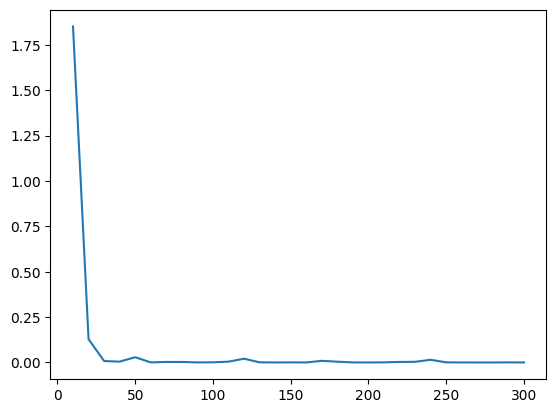

In [ ]:
import matplotlib.pyplot as plt
for epoch in range(30):

    for i, (inputs, labels) in enumerate(train_dataloader, 0):

        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss.item())

plt.plot(counter, loss_history)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_path, test_size=0.2, random_state=0)

train_data_size = len(train)
test_data_size = len(test)

batch_size=8
train_data_loader = DataLoader(train, batch_size=batch_size)
test_data_loader = DataLoader(test, batch_size=batch_size)

In [ ]:
transfer_model = net
print('model copied')

for param in transfer_model.parameters():
    param.requires_grad = False
print('weights are frozen')

transfer_model.cnn1.fc = nn.Sequential(
    nn.Linear(transfer_model.cnn1.fc[0].in_features,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,10)
    )

model copied
weights are frozen


In [ ]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters())

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None
    model = model.to(device)

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/test_data_size
        avg_valid_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        #torch.save(model, '_model_'+str(epoch)+'.pt')

    return model, history, best_epoch

Epoch: 1/20
Epoch : 000, Training: Loss - 1.4179, Accuracy - 53.4247%, 
		Validation : Loss - 0.2400, Accuracy - 100.0000%, Time: 0.7493s
Epoch: 2/20
Epoch : 001, Training: Loss - 0.4517, Accuracy - 83.5616%, 
		Validation : Loss - 0.0297, Accuracy - 100.0000%, Time: 0.4373s
Epoch: 3/20
Epoch : 002, Training: Loss - 0.1420, Accuracy - 97.2603%, 
		Validation : Loss - 0.0153, Accuracy - 100.0000%, Time: 0.5817s
Epoch: 4/20
Epoch : 003, Training: Loss - 0.2224, Accuracy - 91.7808%, 
		Validation : Loss - 0.0020, Accuracy - 100.0000%, Time: 0.4316s
Epoch: 5/20
Epoch : 004, Training: Loss - 0.1258, Accuracy - 95.8904%, 
		Validation : Loss - 0.0069, Accuracy - 100.0000%, Time: 0.4356s
Epoch: 6/20
Epoch : 005, Training: Loss - 0.3000, Accuracy - 93.1507%, 
		Validation : Loss - 0.0010, Accuracy - 100.0000%, Time: 0.4318s
Epoch: 7/20
Epoch : 006, Training: Loss - 0.0657, Accuracy - 98.6301%, 
		Validation : Loss - 0.0022, Accuracy - 100.0000%, Time: 0.5207s
Epoch: 8/20
Epoch : 007, Training:

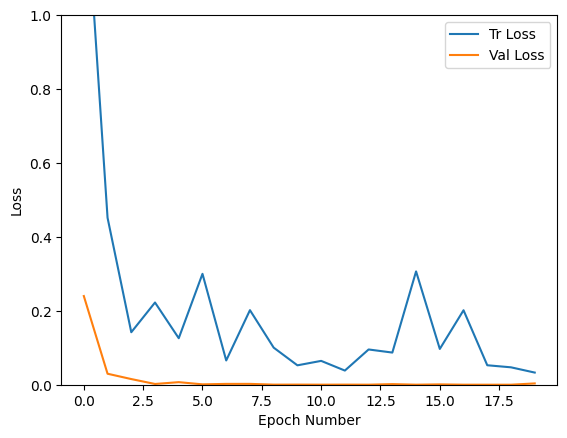

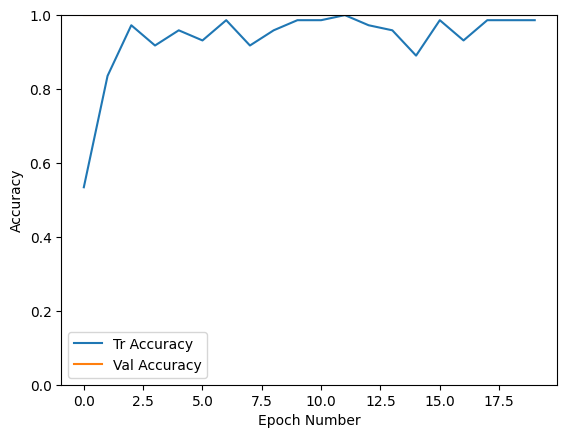

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 20
trained_model, history, best_epoch = train_and_validate(transfer_model, loss_func, optimizer, num_epochs)

#torch.save(history, '_history.pt')
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [ ]:
import torch
from torchvision import datasets, transforms

dataloader = train_dataloader
classes = data_path.classes

# Функция для извлечения признаков
def extract_features(model, dataloader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.cuda()
            features = model(images)
            all_features.append(features.cpu())
            all_labels.append(labels)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels

features, labels = extract_features(net, dataloader)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('logs/pepper')

In [ ]:
class_labels = [classes[lab] for lab in labels]

# log embeddings
writer.add_embedding(features,
                    metadata=class_labels,
                    global_step=0)
writer.close()

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs